In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import seaborn as sns
from scipy.stats import pointbiserialr
from os import getenv
from scrap_reddit import ScrappingPTOrdenado

try:
    from dotenv import load_dotenv
    load_dotenv(".env", encoding='utf8')
    print("Environment variables loaded!")
except Exception as e:
    print(e)

Environment variables loaded!


# Data Extraction

In [2]:

reddit = praw.Reddit(client_id=getenv("CLIENT_ID"), client_secret=getenv("CLIENT_SECRET"), user_agent="praw_scraper_1.0")
subreddit = reddit.subreddit("PTOrdenado")
reddit = ScrappingPTOrdenado(subreddit.new(limit=None))

df = pd.DataFrame(reddit.get_data("IT / Programação", r"data|dados|machine learning|\sai^\w|\sia^\w|inteligência artificial|artificial intelligence"))

# Data analysis

**Title**: Name of the job

**Age**: Age of the person

**Sex**: Sex of the person

**Experience**: Years of experience

**Education**: If has Bachelors or Masters degree

**Labor Hours**: Hours of work per week

**Total Salary**: Salary without taxes, in euros

**Salary**: Salary with taxes applied, in euros

**Mathematics**: If the BsC or MsC is in mathematics or not (it's interesting for me)

In [3]:
df

,Title,Age,Sex,Labor Hours,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,40.0,BsC,No,3.0,Yes,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,40.0,MsC,No,1.0,Yes,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,40.0,MsC,No,1.0,Yes,2050.0,1611.0
3,Data Analyst,26.0,M,36.0,BsC,No,4.0,Yes,2922.0,1870.0
4,Data Analyst,37.0,F,40.0,MsC,No,4.0,Yes,2150.0,1650.0
5,Analista de Dados,26.0,M,40.0,MsC,No,3.0,Yes,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,40.0,BsC,Yes,3.0,No,4460.0,3500.0
7,Data Analyst,28.0,F,40.0,MsC,No,2.0,Yes,1620.0,1220.0
8,Data Engineer,29.0,M,40.0,MsC,No,4.5,Yes,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,40.0,MsC,No,3.0,Yes,2000.0,1523.0


### Salaries
Sometimes salaries are not in decimal representation but in "k" representation, e.g **2k**

Since salaries doesn't pass tens of thousands at maximum, we can verify if salary's remainder by 100 is equal to salary, if yes multiply by 1000, because it didn't pass 100 and anything below 100 can't be a valid Portugal's salary represented in decimal.

In [4]:
df["Salary"] = df["Salary"].apply(lambda x: x * 1000 if x % 100 == x else x)
df["Total Salary"] = df["Total Salary"].apply(lambda x: x * 1000 if x % 100 == x else x)

In [5]:
df

,Title,Age,Sex,Labor Hours,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,40.0,BsC,No,3.0,Yes,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,40.0,MsC,No,1.0,Yes,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,40.0,MsC,No,1.0,Yes,2050.0,1611.0
3,Data Analyst,26.0,M,36.0,BsC,No,4.0,Yes,2922.0,1870.0
4,Data Analyst,37.0,F,40.0,MsC,No,4.0,Yes,2150.0,1650.0
5,Analista de Dados,26.0,M,40.0,MsC,No,3.0,Yes,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,40.0,BsC,Yes,3.0,No,4460.0,3500.0
7,Data Analyst,28.0,F,40.0,MsC,No,2.0,Yes,1620.0,1220.0
8,Data Engineer,29.0,M,40.0,MsC,No,4.5,Yes,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,40.0,MsC,No,3.0,Yes,2000.0,1523.0


# Labor Hours
Since labor hours are constant, for now, and a constant variable will not help in anything, we'll remove it

In [6]:
df.drop(columns=["Labor Hours"], inplace=True)
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,BsC,No,3.0,Yes,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,MsC,No,1.0,Yes,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,MsC,No,1.0,Yes,2050.0,1611.0
3,Data Analyst,26.0,M,BsC,No,4.0,Yes,2922.0,1870.0
4,Data Analyst,37.0,F,MsC,No,4.0,Yes,2150.0,1650.0
5,Analista de Dados,26.0,M,MsC,No,3.0,Yes,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,BsC,Yes,3.0,No,4460.0,3500.0
7,Data Analyst,28.0,F,MsC,No,2.0,Yes,1620.0,1220.0
8,Data Engineer,29.0,M,MsC,No,4.5,Yes,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,MsC,No,3.0,Yes,2000.0,1523.0


# Education
Education is an ordinal variable, because MsC is higher than BsC and PhD higher than MsC. NaN will be no degree.

So we'll use integer values for these variable.

In [7]:
def edu_2_int(x):
    if x == "BsC":
        return 1
    elif x == "MsC":
        return 2
    elif x == "PhD":
        return 3
    return 0

df["Education"] = df["Education"].apply(edu_2_int)

In [8]:
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,1,No,3.0,Yes,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,2,No,1.0,Yes,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,2,No,1.0,Yes,2050.0,1611.0
3,Data Analyst,26.0,M,1,No,4.0,Yes,2922.0,1870.0
4,Data Analyst,37.0,F,2,No,4.0,Yes,2150.0,1650.0
5,Analista de Dados,26.0,M,2,No,3.0,Yes,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,1,Yes,3.0,No,4460.0,3500.0
7,Data Analyst,28.0,F,2,No,2.0,Yes,1620.0,1220.0
8,Data Engineer,29.0,M,2,No,4.5,Yes,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,2,No,3.0,Yes,2000.0,1523.0


# Mathematics and Portugal
Both are nominal variables and are clearly binary variables.

Now, after see the data of both variables, non-portugal workers receive a lot more, so could be useful to determine the salary.

Perhaps, mathematics doesn't seem important.

In [9]:
df["Mathematics"] = df["Mathematics"].apply(lambda x: 1 if x == "Yes" else 0)
df["Portugal"] = df["Portugal"].apply(lambda x: 1 if x == "Yes" else 0)
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,1,0,3.0,1,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,2,0,1.0,1,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,2,0,1.0,1,2050.0,1611.0
3,Data Analyst,26.0,M,1,0,4.0,1,2922.0,1870.0
4,Data Analyst,37.0,F,2,0,4.0,1,2150.0,1650.0
5,Analista de Dados,26.0,M,2,0,3.0,1,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,1,1,3.0,0,4460.0,3500.0
7,Data Analyst,28.0,F,2,0,2.0,1,1620.0,1220.0
8,Data Engineer,29.0,M,2,0,4.5,1,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,2,0,3.0,1,2000.0,1523.0


# Age

Here to fix missing values, using the mean should be reasonable, since the mean will act as a "neutral" value on the variable distribution.

In [10]:
df["Age"].fillna(int(df["Age"].mean()), inplace=True)
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,M,1,0,3.0,1,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,M,2,0,1.0,1,1150.0,1050.0
2,Engenheiro de machine learning,24.0,M,2,0,1.0,1,2050.0,1611.0
3,Data Analyst,26.0,M,1,0,4.0,1,2922.0,1870.0
4,Data Analyst,37.0,F,2,0,4.0,1,2150.0,1650.0
5,Analista de Dados,26.0,M,2,0,3.0,1,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,M,1,1,3.0,0,4460.0,3500.0
7,Data Analyst,28.0,F,2,0,2.0,1,1620.0,1220.0
8,Data Engineer,29.0,M,2,0,4.5,1,3150.0,2000.0
9,Engenheiro de Dados,26.0,M,2,0,3.0,1,2000.0,1523.0


# Sex 
Unfortunately, in this small sample we can observe a lot more males than females working. Since it's a nominal variable, we will just use mode.

If the sample increase and more NaN appear than a dummy variable will be create to support "Other" option on this variable.

For now it'll be a binary variable

In [11]:
df["Sex"].fillna(df["Sex"].mode()[0], inplace=True)
df["Sex"] = df["Sex"].apply(lambda x: 1 if x == "M" else 0)
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,34.0,1,1,0,3.0,1,2700.0,1877.0
1,Estagiário Análise de Dados,23.0,1,2,0,1.0,1,1150.0,1050.0
2,Engenheiro de machine learning,24.0,1,2,0,1.0,1,2050.0,1611.0
3,Data Analyst,26.0,1,1,0,4.0,1,2922.0,1870.0
4,Data Analyst,37.0,0,2,0,4.0,1,2150.0,1650.0
5,Analista de Dados,26.0,1,2,0,3.0,1,2600.0,1800.0
6,Data Scientist Luxemburgo,24.0,1,1,1,3.0,0,4460.0,3500.0
7,Data Analyst,28.0,0,2,0,2.0,1,1620.0,1220.0
8,Data Engineer,29.0,1,2,0,4.5,1,3150.0,2000.0
9,Engenheiro de Dados,26.0,1,2,0,3.0,1,2000.0,1523.0


## Standardization
Standardization will result in the same porpotion for all variables.

The only variables we'll not standardize are the binary ones, unless we use PCA or some algoritm sensible to different scales.

In [12]:
cols = df.columns

for c in (set(cols) - {"Title", "Sex", "Mathematics", "Portugal"}):
    df[c] = df[c].apply(lambda x: (x - df[c].mean())/df[c].std())
df

,Title,Age,Sex,Education,Mathematics,Experience,Portugal,Total Salary,Salary
0,Data Engineer,1.079258,1,-0.881631,0,-0.476087,1,-0.281212,-0.386123
1,Estagiário Análise de Dados,-1.160711,1,0.587754,0,-1.156211,1,-1.430680,-1.307825
2,Engenheiro de machine learning,-0.957078,1,0.587754,0,-1.156211,1,-0.763247,-0.682583
3,Data Analyst,-0.549810,1,-0.881631,0,-0.136025,1,-0.116578,-0.393925
4,Data Analyst,1.690158,0,0.587754,0,-0.136025,1,-0.689088,-0.639117
5,Analista de Dados,-0.549810,1,0.587754,0,-0.476087,1,-0.355371,-0.471940
6,Data Scientist Luxemburgo,-0.957078,1,-0.881631,1,-0.476087,0,1.023991,1.422731
7,Data Analyst,-0.142543,0,0.587754,0,-0.816149,1,-1.082132,-1.118358
8,Data Engineer,0.061090,1,0.587754,0,0.034006,1,0.052505,-0.249038
9,Engenheiro de Dados,-0.549810,1,0.587754,0,-0.476087,1,-0.800327,-0.780661


## Linear dependencies

Let's check how linearly correlated are each variable.

`Title` will be removed because the first one is just for being informative.
All categorical variables are being removed because Pearson coeficient is not appropriate for this kind of variables.

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Education', ylabel='Age'>,
        <Axes: xlabel='Experience', ylabel='Age'>,
        <Axes: xlabel='Total Salary', ylabel='Age'>,
        <Axes: xlabel='Salary', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Education'>,
        <Axes: xlabel='Education', ylabel='Education'>,
        <Axes: xlabel='Experience', ylabel='Education'>,
        <Axes: xlabel='Total Salary', ylabel='Education'>,
        <Axes: xlabel='Salary', ylabel='Education'>],
       [<Axes: xlabel='Age', ylabel='Experience'>,
        <Axes: xlabel='Education', ylabel='Experience'>,
        <Axes: xlabel='Experience', ylabel='Experience'>,
        <Axes: xlabel='Total Salary', ylabel='Experience'>,
        <Axes: xlabel='Salary', ylabel='Experience'>],
       [<Axes: xlabel='Age', ylabel='Total Salary'>,
        <Axes: xlabel='Education', ylabel='Total Salary'>,
        <Axes: xlabel='Experience', ylabel='Total Salary'>,
        <Axes: xlabel='To

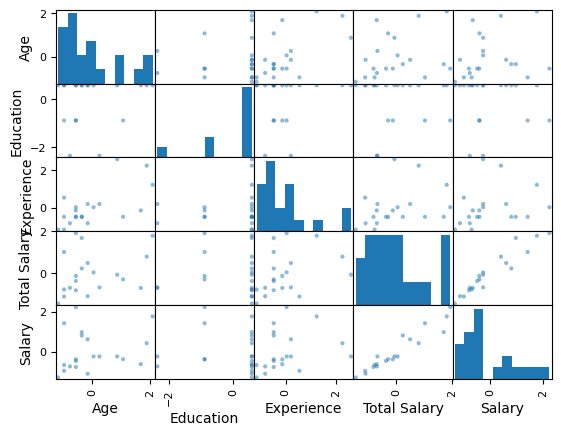

In [15]:
df_train = df.drop(columns=["Title"])
df_continuous = df_train.drop(columns=["Portugal", "Mathematics", "Sex"])
pd.plotting.scatter_matrix(df_continuous)

In [16]:
df_continuous.corr()

,Age,Education,Experience,Total Salary,Salary
Age,1.000000,0.151183,0.652025,0.296162,0.217966
Education,0.151183,1.000000,0.176204,0.010817,-0.068299
Experience,0.652025,0.176204,1.000000,0.349822,0.278685
Total Salary,0.296162,0.010817,0.349822,1.000000,0.955251
Salary,0.217966,-0.068299,0.278685,0.955251,1.000000


**Positively correlated**
* `Age` and `Experience` - More age implies in more experience
* `Salary` and `Total Salary` - As expected, if your total salary is high your final salary will be too.


Other variables have little positive correlation by the numbers or by the graph, but don't seem important.


For comparing categorical nominal variables like `Sex` and `Portugal` with other continuos variables, will be used Point-biserial correlation.